In [1]:
# Gerekli kütüphaneleri import edelim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-04-11 12:23:14.844141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744374195.085178      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744374195.155343      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Veri setinin okunması
df = pd.read_csv("/kaggle/input/ckdataset/ckextended.csv")

In [3]:
# Duygu etiketleri
emotion_labels = {
    0: "Anger (Öfke)",
    1: "Disgust (İğrenme)",
    2: "Fear (Korku)",
    3: "Happiness (Mutluluk)",
    4: "Sadness (Üzüntü)",
    5: "Surprise (Şaşırma)",
    6: "Neutral (Nötr)",
    7: "Contempt (Küçümseme)"
}

# Sınıf dağılımını kontrol etme
print("Sınıf Dağılımı:")
print(df['emotion'].value_counts().sort_index())

Sınıf Dağılımı:
emotion
0     45
1     59
2     25
3     69
4     28
5     83
6    593
7     18
Name: count, dtype: int64


In [4]:
# Nötr sınıftan örnek azaltma
neutral_idx = df[df['emotion'] == 6].index
np.random.seed(42)
neutral_sample_idx = np.random.choice(neutral_idx, size=100, replace=False)
non_neutral_idx = df[df['emotion'] != 6].index
balanced_idx = np.concatenate([non_neutral_idx, neutral_sample_idx])
df_balanced = df.loc[balanced_idx]

In [5]:
# Piksel verilerinin dönüştürülmesi
df_balanced['pixels'] = df_balanced['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))

# Görüntü boyutları
img_size = 48

# Numpy dizisine çevirme
X = np.stack(df_balanced['pixels'].values)
X = X.reshape(-1, img_size, img_size, 1)
X = X / 255.0  # Normalizasyon

# Etiketleri one-hot encoding'e çevirme
y = to_categorical(df_balanced['emotion'])

# Eğitim, doğrulama ve test kümelerine ayırma
train_idx = df_balanced['Usage'] == 'Training'
val_idx = df_balanced['Usage'] == 'PublicTest'
test_idx = (df_balanced['Usage'] == 'PublicTest') | (df_balanced['Usage'] == 'PrivateTest')  # Test setini birleştirme

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Eğitim verisini karıştırma
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Test seti boyutunu ve sınıf dağılımını kontrol etme
print("Test seti boyutu:", X_test.shape[0])
print("Test seti sınıf dağılımı:")
print(pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index())

# Class weights hesaplama
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Test seti boyutu: 89
Test seti sınıf dağılımı:
0     9
1    12
2     5
3    14
4     6
5    17
6    22
7     4
Name: count, dtype: int64
Class Weights: {0: 1.1736111111111112, 1: 0.898936170212766, 2: 2.1125, 3: 0.7681818181818182, 4: 1.9204545454545454, 5: 0.6401515151515151, 6: 0.5416666666666666, 7: 3.017857142857143}


In [6]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

In [7]:
# -----------------------
# BASİT MODEL
# -----------------------
print("\n=== Basit Model Eğitimi ===")

# Basit model oluşturma
model_simple = Sequential()

model_simple.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(64, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))
model_simple.add(Dropout(0.3))

model_simple.add(Flatten())

model_simple.add(Dense(64, activation='relu'))
model_simple.add(Dropout(0.3))

model_simple.add(Dense(8, activation='softmax'))

# Model derleme
model_simple.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti
model_simple.summary()


=== Basit Model Eğitimi ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-11 12:23:32.044103: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 429,000 (1.64 MB)

 Trainable params: 429,000 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Model eğitimi
history_simple = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1855 - loss: 2.0581 - val_accuracy: 0.3250 - val_loss: 2.0669 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1778 - loss: 1.9910 - val_accuracy: 0.3500 - val_loss: 2.0459 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3422 - loss: 2.0825 - val_accuracy: 0.2750 - val_loss: 1.9633 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3403 - loss: 2.0487 - val_accuracy: 0.3000 - val_loss: 1.8915 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3415 - loss: 1.9330 - val_accuracy: 0.4250 - val_loss: 1.7451 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4431 - loss: 1.7622 - val_accuracy: 0.5500 - val_loss: 1.5350 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4831 - loss: 1.6052 - val_acc

In [9]:
# Test seti üzerinde değerlendirme
test_loss_simple, test_acc_simple = model_simple.evaluate(X_test, y_test, verbose=0)
print(f"Basit Model - Test Accuracy: {test_acc_simple:.4f}")
print(f"Basit Model - Test Loss: {test_loss_simple:.4f}")

Basit Model - Test Accuracy: 0.6966
Basit Model - Test Loss: 0.7615


In [10]:
# Tahminler
y_pred_simple = model_simple.predict(X_test)
y_pred_classes_simple = np.argmax(y_pred_simple, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Sınıf bazlı değerlendirme
print("Basit Model - Sınıf Bazlı Değerlendirme:")
print(classification_report(y_test_classes, y_pred_classes_simple, target_names=emotion_labels.values()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Basit Model - Sınıf Bazlı Değerlendirme:
                      precision    recall  f1-score   support

        Anger (Öfke)       0.50      0.22      0.31         9
   Disgust (İğrenme)       0.83      0.83      0.83        12
        Fear (Korku)       0.67      0.40      0.50         5
Happiness (Mutluluk)       0.87      0.93      0.90        14
    Sadness (Üzüntü)       0.33      0.33      0.33         6
  Surprise (Şaşırma)       0.94      0.88      0.91        17
      Neutral (Nötr)       0.55      0.73      0.63        22
Contempt (Küçümseme)       0.50      0.50      0.50         4

            accuracy                           0.70        89
           macro avg       0.65      0.60      0.61        89
        weighted avg       0.70      0.70      0.69        89



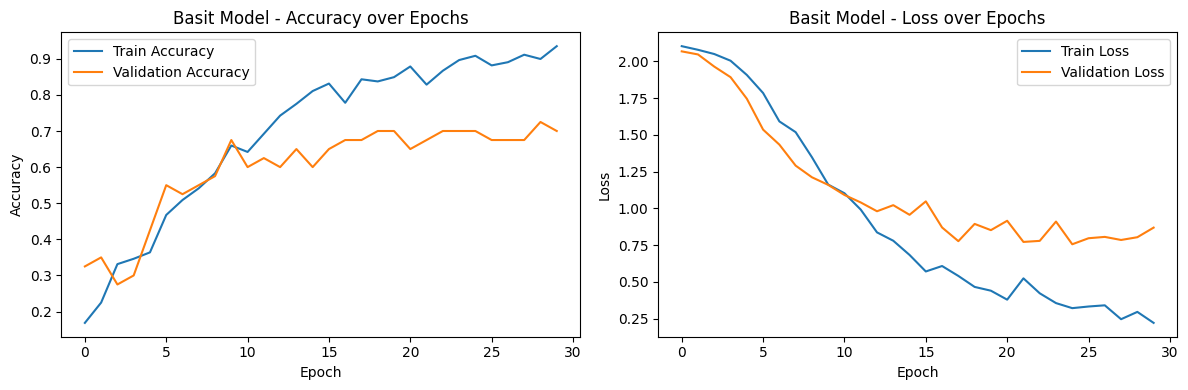

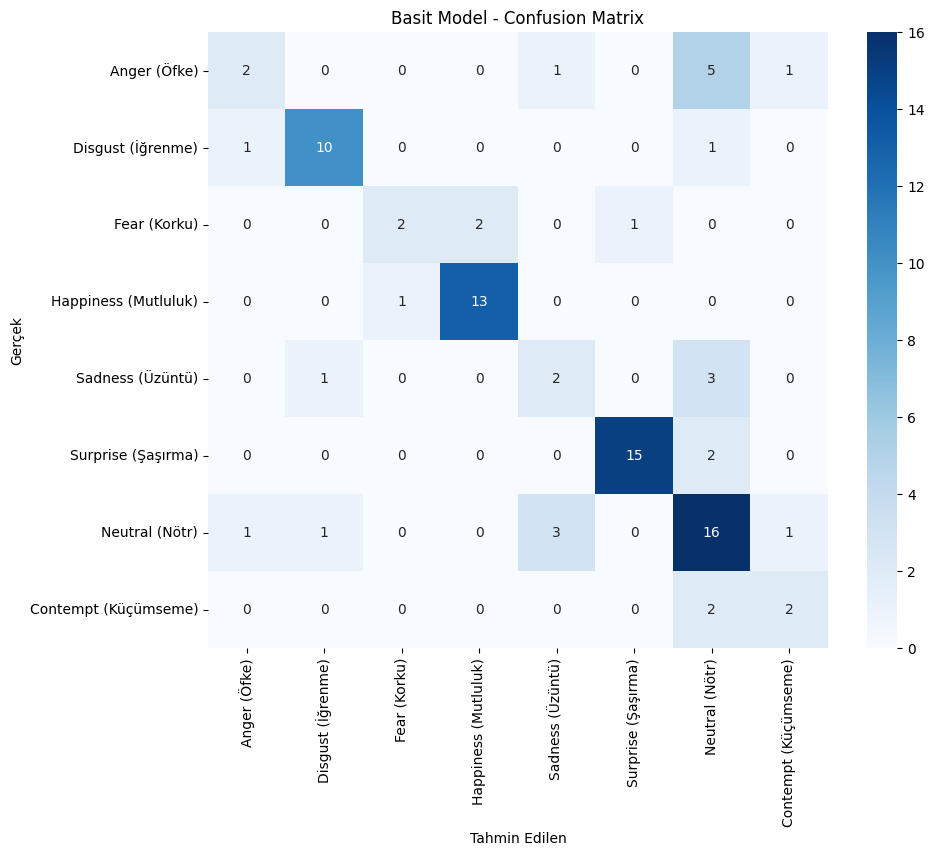

In [11]:
# Çizimler
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Basit Model - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Basit Model - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm_simple = confusion_matrix(y_test_classes, y_pred_classes_simple)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Basit Model - Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


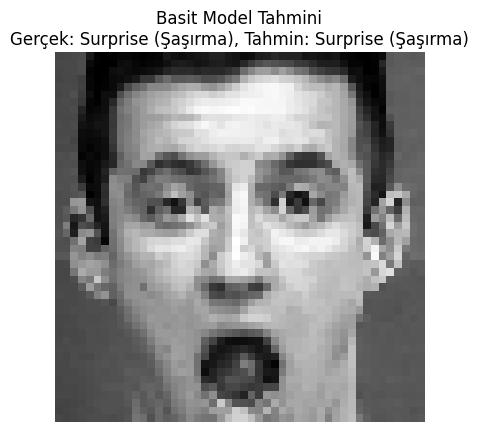

In [12]:
# Örnek bir resim tahmini (test setinden rastgele bir örnek)
random_idx = np.random.randint(0, X_test.shape[0])
sample_image = X_test[random_idx]
sample_label = y_test_classes[random_idx]

# Tahmin 
sample_pred = model_simple.predict(sample_image.reshape(1, 48, 48, 1))
sample_pred_class = np.argmax(sample_pred, axis=1)[0]

# Görselleştirme
plt.imshow(sample_image.reshape(48, 48), cmap='gray')
plt.title(f"Basit Model Tahmini\nGerçek: {emotion_labels[sample_label]}, Tahmin: {emotion_labels[sample_pred_class]}")
plt.axis('off')
plt.show()

In [13]:
# -----------------------
# YENİ MODEL
# -----------------------
print("\n=== Yeni Model Eğitimi ===")

# Yeni model oluşturma
model_new = Sequential()

model_new.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(48, 48, 1)))
model_new.add(MaxPooling2D((2, 2)))

model_new.add(Conv2D(128, (3, 3), activation='relu'))
model_new.add(MaxPooling2D((2, 2)))
model_new.add(Dropout(0.5))

model_new.add(Conv2D(256, (3, 3), activation='relu'))
model_new.add(MaxPooling2D((2, 2)))

model_new.add(Flatten())

model_new.add(Dense(128, activation='relu'))
model_new.add(Dropout(0.5))

model_new.add(Dense(8, activation='softmax'))

# Model derleme
model_new.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti
model_new.summary()


=== Yeni Model Eğitimi ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 895,112 (3.41 MB)

 Trainable params: 895,112 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Model eğitimi
history_new = model_new.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.1781 - loss: 2.1254 - val_accuracy: 0.2750 - val_loss: 2.0797
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.1297 - loss: 2.0785 - val_accuracy: 0.1500 - val_loss: 2.0852
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.1472 - loss: 2.0871 - val_accuracy: 0.1750 - val_loss: 2.0840
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.1624 - loss: 2.0650 - val_accuracy: 0.3000 - val_loss: 2.0830
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.2118 - loss: 2.1548 - val_accuracy: 0.2500 - val_loss: 2.0429
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.2073 - loss: 2.0215 - val_accuracy: 0.3000 - val_loss: 2.0476
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.2379 - loss: 2.1060 - val_accuracy: 0.3750 - val_loss: 2.0078
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.2587 - loss: 1.9976 - val_accuracy: 0.4750 - val_loss:

In [15]:
# Test seti üzerinde değerlendirme
test_loss_new, test_acc_new = model_new.evaluate(X_test, y_test, verbose=0)
print(f"Yeni Model - Test Accuracy: {test_acc_new:.4f}")
print(f"Yeni Model - Test Loss: {test_loss_new:.4f}")

Yeni Model - Test Accuracy: 0.7191
Yeni Model - Test Loss: 0.8753


In [16]:
# Tahminler
y_pred_new = model_new.predict(X_test)
y_pred_classes_new = np.argmax(y_pred_new, axis=1)

# Sınıf bazlı değerlendirme
print("Yeni Model - Sınıf Bazlı Değerlendirme:")
print(classification_report(y_test_classes, y_pred_classes_new, target_names=emotion_labels.values()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Yeni Model - Sınıf Bazlı Değerlendirme:
                      precision    recall  f1-score   support

        Anger (Öfke)       0.46      0.67      0.55         9
   Disgust (İğrenme)       0.91      0.83      0.87        12
        Fear (Korku)       0.43      0.60      0.50         5
Happiness (Mutluluk)       0.93      1.00      0.97        14
    Sadness (Üzüntü)       0.33      0.33      0.33         6
  Surprise (Şaşırma)       1.00      0.94      0.97        17
      Neutral (Nötr)       0.65      0.59      0.62        22
Contempt (Küçümseme)       0.00      0.00      0.00         4

            accuracy                           0.72        89
           macro avg       0.59      0.62      0.60        89
        weighted avg       0.71      0.72      0.71        89



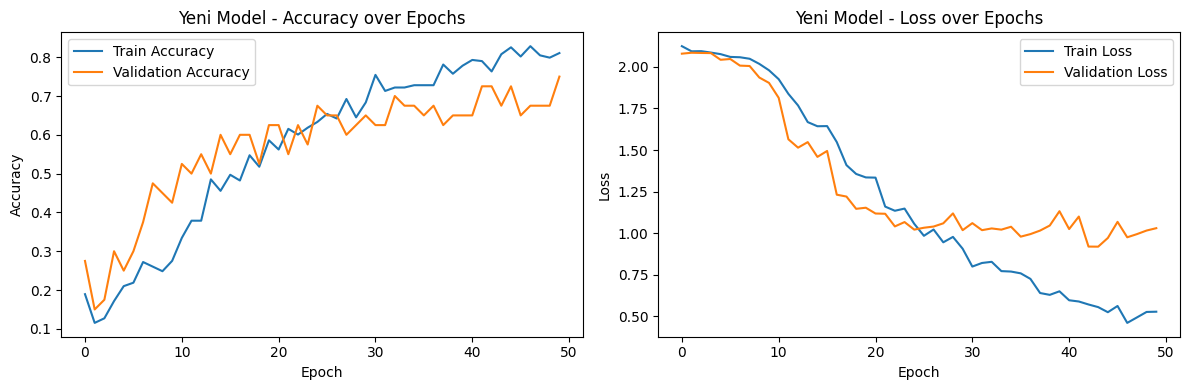

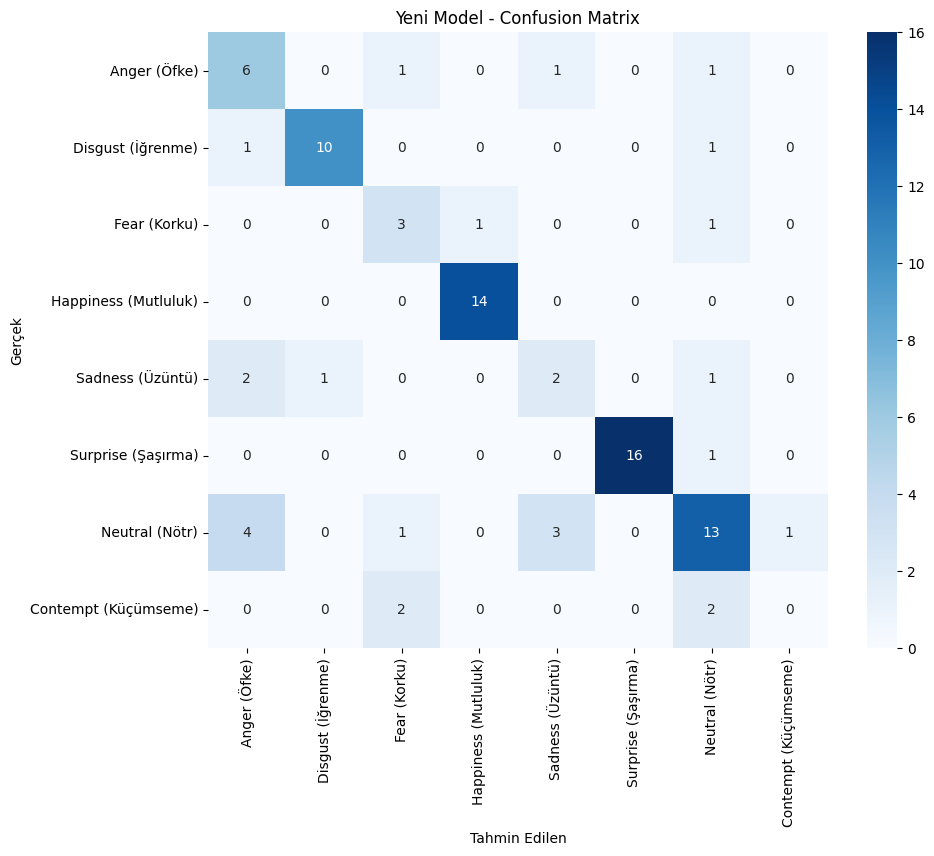

In [17]:
# Çizimler
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Yeni Model - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('Yeni Model - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm_new = confusion_matrix(y_test_classes, y_pred_classes_new)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Yeni Model - Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


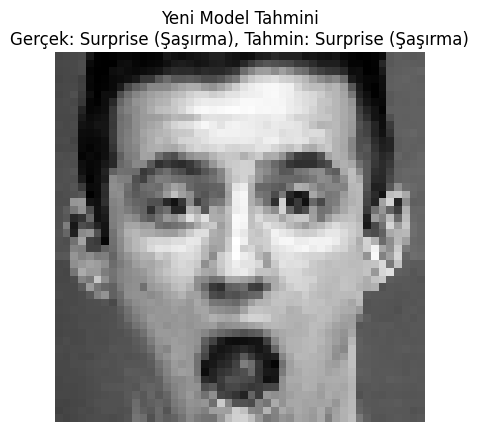

In [18]:
# Aynı örnek resim üzerinde tahmin (basit modelde kullanılan örnek)
sample_pred_new = model_new.predict(sample_image.reshape(1, 48, 48, 1))
sample_pred_class_new = np.argmax(sample_pred_new, axis=1)[0]

# Görselleştirme
plt.imshow(sample_image.reshape(48, 48), cmap='gray')
plt.title(f"Yeni Model Tahmini\nGerçek: {emotion_labels[sample_label]}, Tahmin: {emotion_labels[sample_pred_class_new]}")
plt.axis('off')
plt.show()

In [19]:
# -----------------------
# SONUÇLARIN KARŞILAŞTIRILMASI
# -----------------------
print("\n=== Modellerin Karşılaştırılması ===")

print("Basit Model Sonuçları:")
print(f"Test Accuracy: {test_acc_simple:.4f}")
print(f"Test Loss: {test_loss_simple:.4f}")
print(classification_report(y_test_classes, y_pred_classes_simple, target_names=emotion_labels.values()))

print("\nYeni Model Sonuçları:")
print(f"Test Accuracy: {test_acc_new:.4f}")
print(f"Test Loss: {test_loss_new:.4f}")
print(classification_report(y_test_classes, y_pred_classes_new, target_names=emotion_labels.values()))


=== Modellerin Karşılaştırılması ===
Basit Model Sonuçları:
Test Accuracy: 0.6966
Test Loss: 0.7615
                      precision    recall  f1-score   support

        Anger (Öfke)       0.50      0.22      0.31         9
   Disgust (İğrenme)       0.83      0.83      0.83        12
        Fear (Korku)       0.67      0.40      0.50         5
Happiness (Mutluluk)       0.87      0.93      0.90        14
    Sadness (Üzüntü)       0.33      0.33      0.33         6
  Surprise (Şaşırma)       0.94      0.88      0.91        17
      Neutral (Nötr)       0.55      0.73      0.63        22
Contempt (Küçümseme)       0.50      0.50      0.50         4

            accuracy                           0.70        89
           macro avg       0.65      0.60      0.61        89
        weighted avg       0.70      0.70      0.69        89


Yeni Model Sonuçları:
Test Accuracy: 0.7191
Test Loss: 0.8753
                      precision    recall  f1-score   support

        Anger (Öfke)      


=== Tüm Duygu Durumlarına Ait Örnekler Üzerinde Tahmin ===


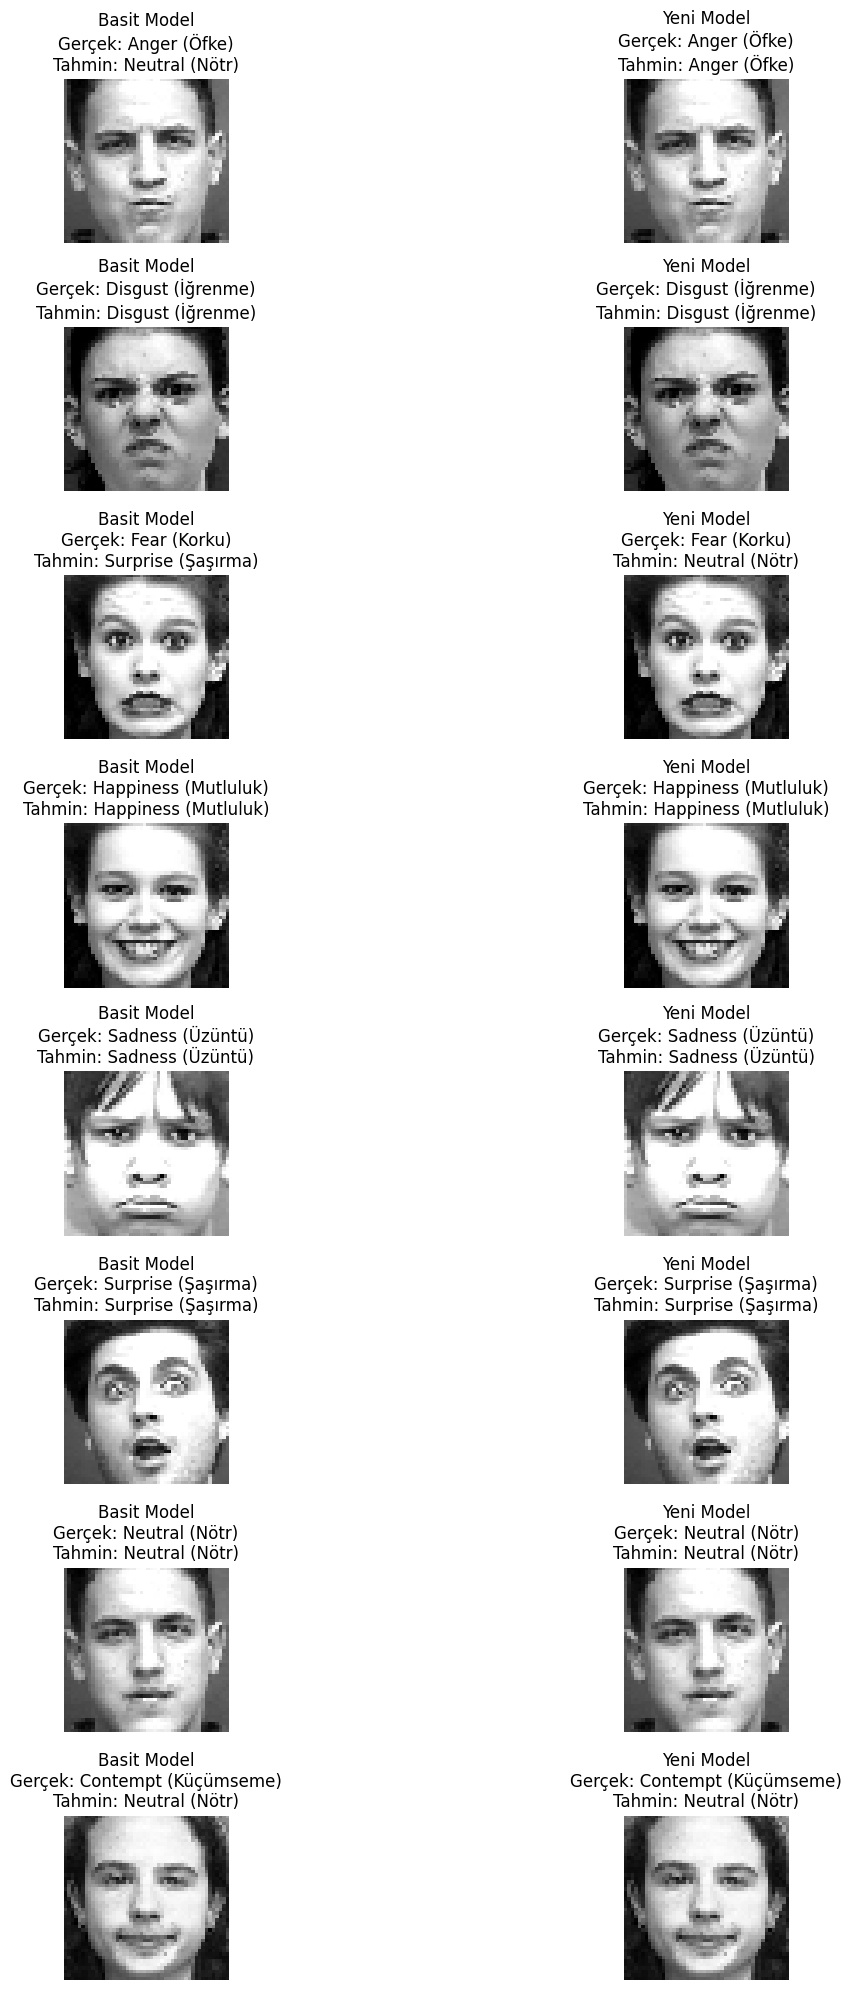

In [20]:
# -----------------------
# TÜM DUYGU DURUMLARINA AİT ÖRNEKLER ÜZERİNDE TAHMİN
# -----------------------
print("\n=== Tüm Duygu Durumlarına Ait Örnekler Üzerinde Tahmin ===")

# Test setindeki duygu durumlarını al
y_test_classes = np.argmax(y_test, axis=1)

# Her duygu durumu için birer örnek seç
emotion_indices = {}
for emotion in range(8):  # 0'dan 7'ye kadar tüm duygu durumları
    indices = np.where(y_test_classes == emotion)[0]
    if len(indices) > 0:
        emotion_indices[emotion] = indices[0]  # İlk örneği seç
    else:
        print(f"{emotion_labels[emotion]} için test setinde örnek bulunamadı.")

# Seçilen örnekler üzerinde tahmin yap ve görselleştir
plt.figure(figsize=(15, 20))
for i, (emotion, idx) in enumerate(emotion_indices.items()):
    # Örnek resmi al
    sample_image = X_test[idx]
    sample_label = y_test_classes[idx]

    # Basit model tahmini
    sample_pred_simple = model_simple.predict(sample_image.reshape(1, 48, 48, 1), verbose=0)
    sample_pred_class_simple = np.argmax(sample_pred_simple, axis=1)[0]

    # Yeni model tahmini
    sample_pred_new = model_new.predict(sample_image.reshape(1, 48, 48, 1), verbose=0)
    sample_pred_class_new = np.argmax(sample_pred_new, axis=1)[0]

    # Görselleştirme (her duygu durumu için bir satır, iki sütun: Basit Model ve Yeni Model)
    # Basit Model Tahmini
    plt.subplot(len(emotion_indices), 2, 2 * i + 1)
    plt.imshow(sample_image.reshape(48, 48), cmap='gray')
    plt.title(f"Basit Model\nGerçek: {emotion_labels[sample_label]}\nTahmin: {emotion_labels[sample_pred_class_simple]}")
    plt.axis('off')

    # Yeni Model Tahmini
    plt.subplot(len(emotion_indices), 2, 2 * i + 2)
    plt.imshow(sample_image.reshape(48, 48), cmap='gray')
    plt.title(f"Yeni Model\nGerçek: {emotion_labels[sample_label]}\nTahmin: {emotion_labels[sample_pred_class_new]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Sonuçları bir dosyaya kaydetme
with open('model_comparison.txt', 'w') as f:
    f.write("Basit Model Sonuçları\n")
    f.write(f"Test Accuracy: {test_acc_simple:.4f}\n")
    f.write(f"Test Loss: {test_loss_simple:.4f}\n")
    f.write(classification_report(y_test_classes, y_pred_classes_simple, target_names=emotion_labels.values()))
    f.write("\n\nYeni Model Sonuçları\n")
    f.write(f"Test Accuracy: {test_acc_new:.4f}\n")
    f.write(f"Test Loss: {test_loss_new:.4f}\n")
    f.write(classification_report(y_test_classes, y_pred_classes_new, target_names=emotion_labels.values()))